#### Jupyter Notebook for importing and plotting census neighborhoods and block groups, plotting points from the article 80 and approved datasets, performing spacial and attribute joins, plotting per-demographic group Lorenz curves and finding per-demographic group Gini coefficients

##### Made by Efim Sokolov

In [2]:
import pandas as pd
import geopandas as gpd
# from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import contextily as cx # background map

#### Census Neighborhoods

In [3]:
census = gpd.read_file('./census_neighborhoods/Census2020_BG_Neighborhoods.shp')
census.head()

OBJECTID   BlockGr202    Shape_Leng    Shape_Area  \
0         1      Allston  35808.619278  4.154760e+07   
1         2     Back Bay  18815.103609  1.538724e+07   
2         3  Beacon Hill  11668.951169  7.891524e+06   
3         4     Brighton  47051.804654  7.658156e+07   
4         5  Charlestown  33910.754786  5.127021e+07   

                                            geometry  
0  POLYGON ((758525.831 2959265.091, 758671.805 2...  
1  POLYGON ((771539.219 2954877.239, 771575.861 2...  
2  POLYGON ((774297.440 2956963.715, 774312.270 2...  
3  POLYGON ((754177.850 2955969.986, 754151.917 2...  
4  POLYGON ((773132.501 2968902.714, 773021.919 2...

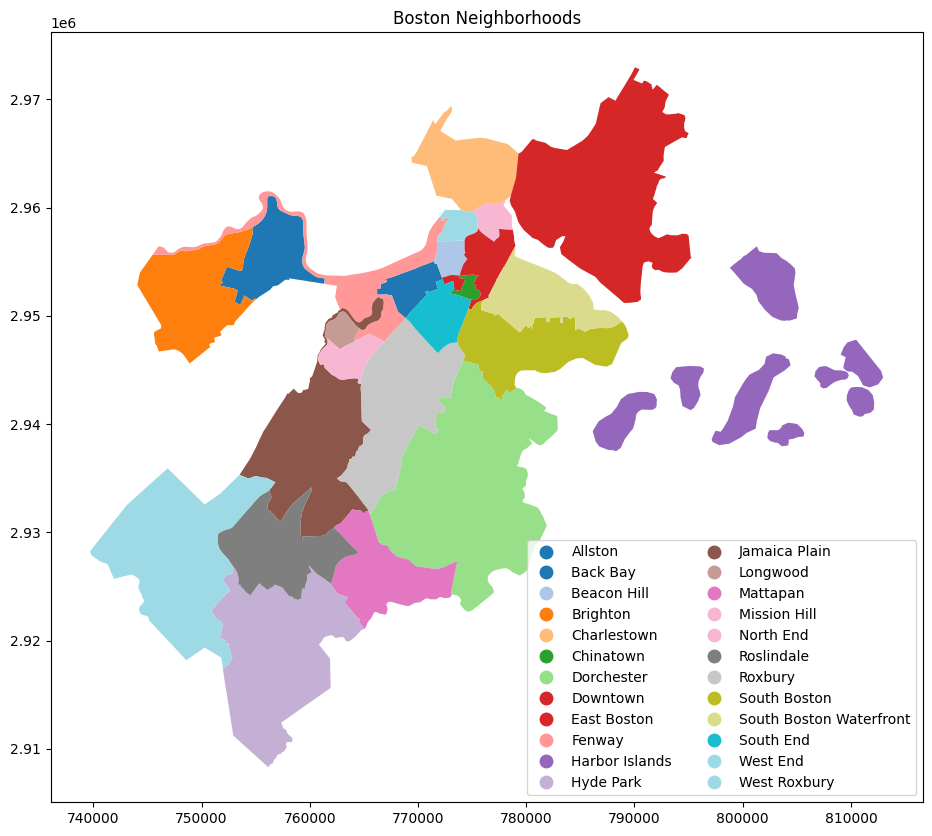

In [4]:
census.plot(column="BlockGr202", categorical=True, legend=True, cmap="tab20", figsize=(20, 10),
            legend_kwds={"loc": "lower right", "ncol": 2})
plt.title('Boston Neighborhoods')
plt.show()

In [5]:
census.crs

<Projected CRS: PROJCS["NAD83 / Massachusetts Mainland (ftUS)",GEO ...>
Name: NAD83 / Massachusetts Mainland (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Approved dataset

In [6]:
abp = pd.read_csv("./proj_data/cleaned_abp.csv")
abp.dropna(subset=["long", "lat"], inplace=True)

Number of points 607822


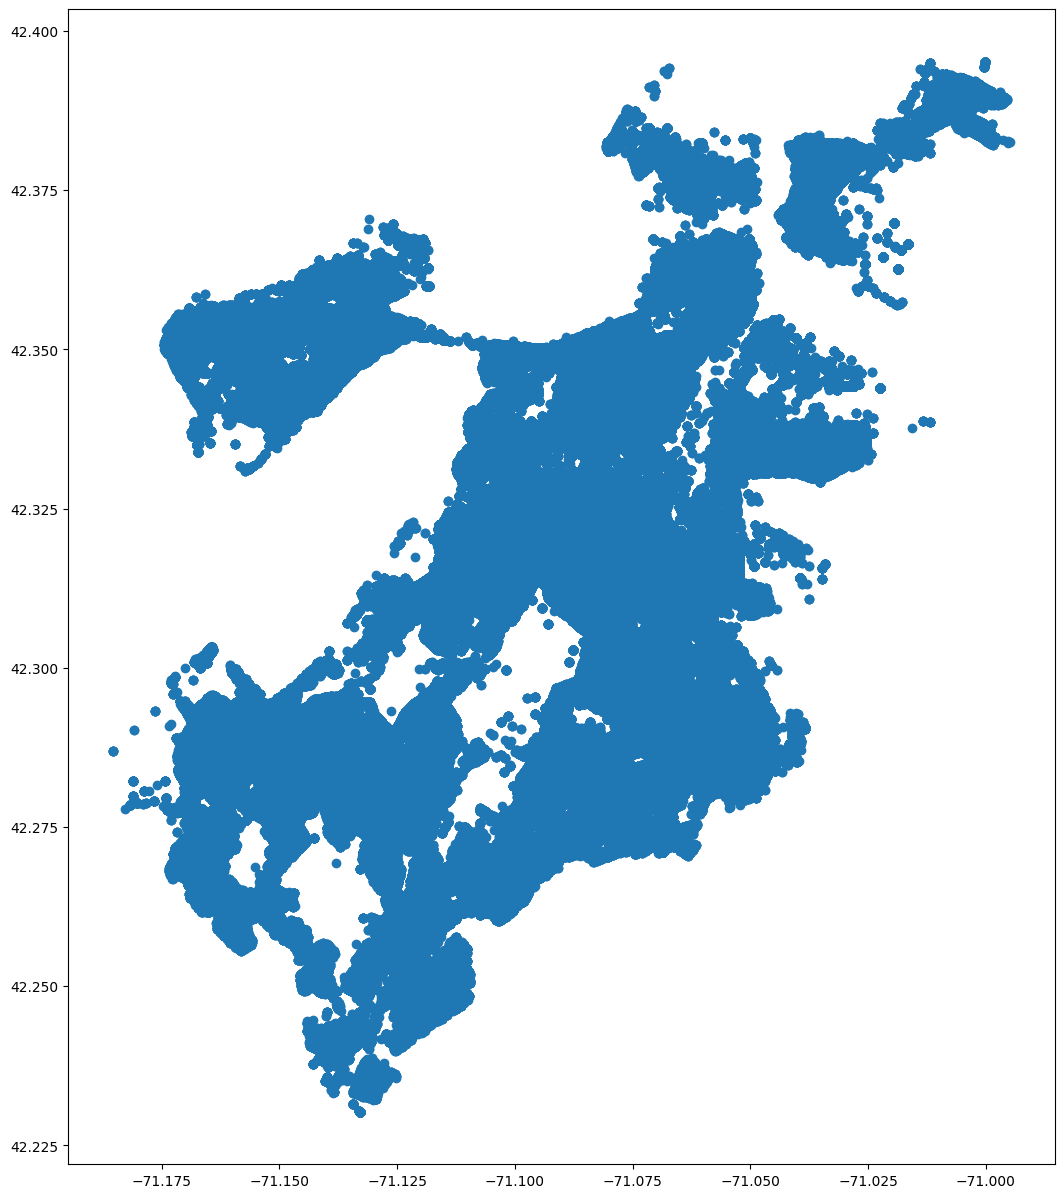

In [7]:
gabp = gpd.GeoDataFrame(
    abp, geometry=gpd.points_from_xy(abp["long"], abp["lat"], crs="EPSG:4326")
)
gabp.plot(figsize=(20, 15))
print(f'Number of points {gabp["geometry"].count()}')
# del abp, gabp # free up memory

In [8]:
a80 = pd.read_csv("./proj_data/cleaned_a80.csv")
a80.dropna(subset=["lon", "lat"], inplace=True)

Number of points 1762


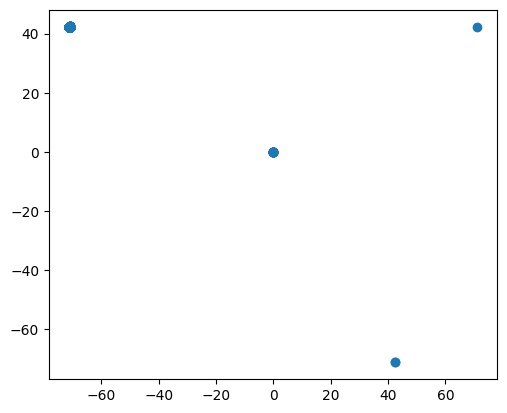

In [9]:
ga80 = gpd.GeoDataFrame(
    a80, geometry=gpd.points_from_xy(a80["lon"], a80["lat"], crs="EPSG:4326")
)
ga80.plot()
print(f'Number of points {ga80["geometry"].count()}')

Filtered later

In [10]:
# clean memory
del ga80, a80, abp

In [11]:
# Change coordinate system so geometries can be overlayed
gabp.to_crs(census.crs, inplace=True)

<Axes: >

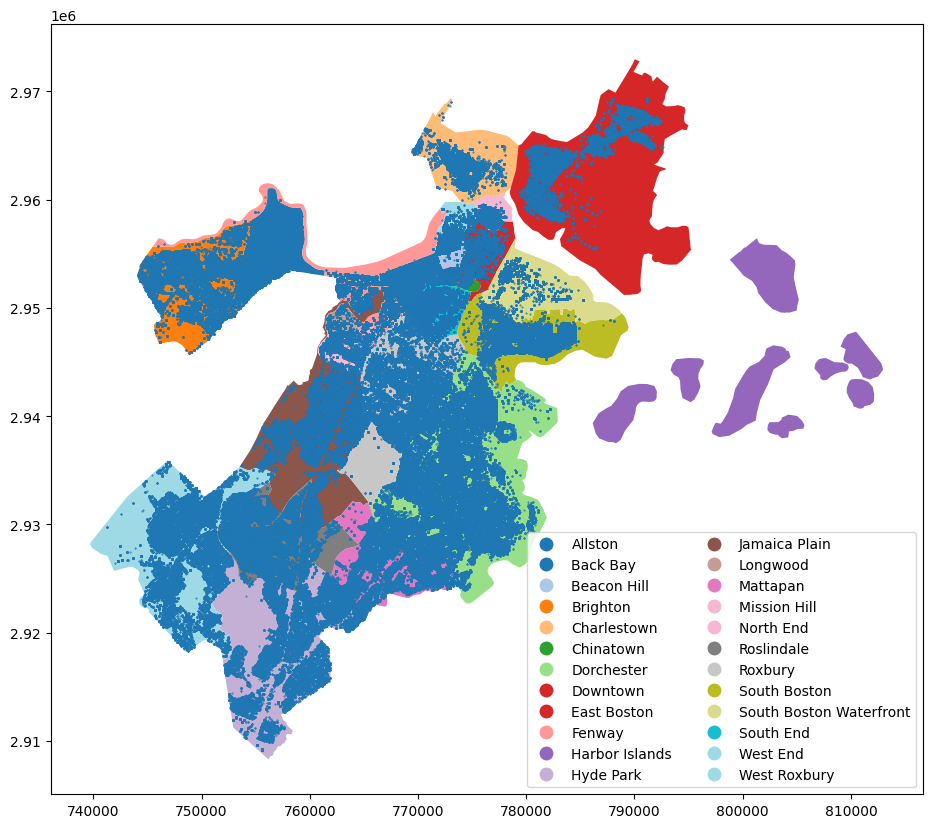

In [12]:
ax = census.plot(column="BlockGr202", categorical=True, legend=True, cmap="tab20", figsize=(20, 10),
            legend_kwds={"loc": "lower right", "ncol": 2})
gabp.plot(ax=ax, markersize=0.2)

#### Spacial join

In [13]:
num_per_neighborhood = census.sjoin(gabp, predicate="contains").groupby("BlockGr202").size()
num_per_neighborhood["Harbor Islands"] = 0
num_per_neighborhood

BlockGr202
Allston                    13908
Back Bay                   43429
Beacon Hill                13145
Brighton                   25547
Charlestown                20618
Chinatown                   4984
Dorchester                 79023
Downtown                   60125
East Boston                27940
Fenway                     20161
Hyde Park                  26823
Jamaica Plain              37886
Longwood                   12675
Mattapan                   17406
Mission Hill                7713
North End                   9209
Roslindale                 25551
Roxbury                    34261
South Boston               31250
South Boston Waterfront    19333
South End                  35354
West End                    9335
West Roxbury               32135
Harbor Islands                 0
dtype: int64

#### Attribute join development count column with census neighborhoods by index

In [14]:
census = census.merge(num_per_neighborhood.rename("point counts"), left_on="BlockGr202", right_on=num_per_neighborhood.index)

<Axes: >

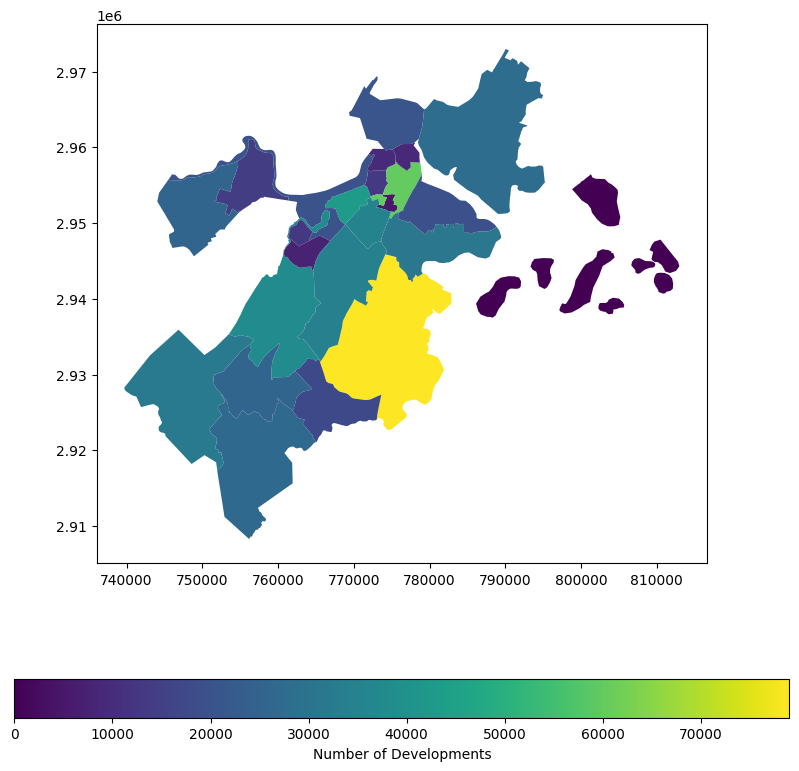

In [15]:
census.plot(column="point counts", legend=True, cmap="viridis", figsize=(10, 10),\
                     legend_kwds={'label': "Number of Developments",
                         'orientation': "horizontal"})

In [16]:
# print(num_per_neighborhood)
num_per_neighborhood.index = [i if i != "South Boston Waterfront" else "S. Boston Waterfront" for i in num_per_neighborhood.index]
num_per_neighborhood.index

Index(['Allston', 'Back Bay', 'Beacon Hill', 'Brighton', 'Charlestown',
       'Chinatown', 'Dorchester', 'Downtown', 'East Boston', 'Fenway',
       'Hyde Park', 'Jamaica Plain', 'Longwood', 'Mattapan', 'Mission Hill',
       'North End', 'Roslindale', 'Roxbury', 'South Boston',
       'S. Boston Waterfront', 'South End', 'West End', 'West Roxbury',
       'Harbor Islands'],
      dtype='object')

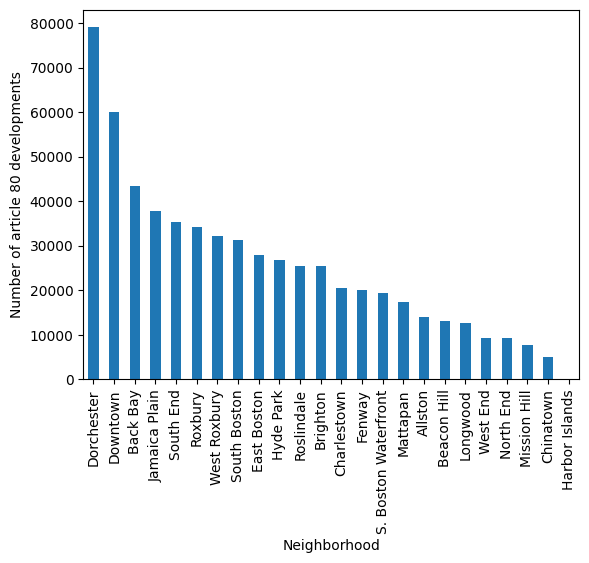

In [17]:
ax = num_per_neighborhood.sort_values(ascending=False).plot(kind="bar")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Number of article 80 developments")
plt.savefig("nums_neighborhoods", bbox_inches='tight')

In [18]:
# Transform to Web Mercador coordinate system
census.to_crs(epsg=3857, inplace=True)
gabp.to_crs(epsg=3857, inplace=True)

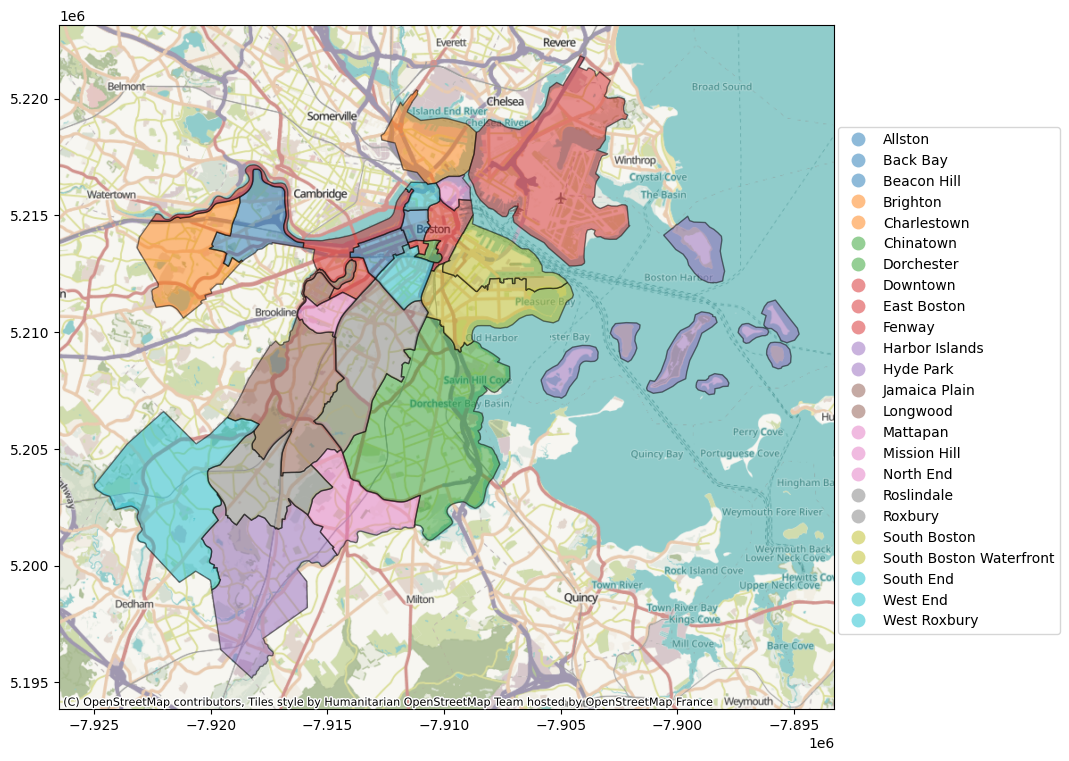

In [19]:
ax = census.plot(figsize=(10, 10), alpha=0.5, edgecolor="k",  column="BlockGr202",
                 legend=True, legend_kwds={"loc": "lower right", "bbox_to_anchor":(1.3, 0.1)})
cx.add_basemap(ax, crs=census.crs)


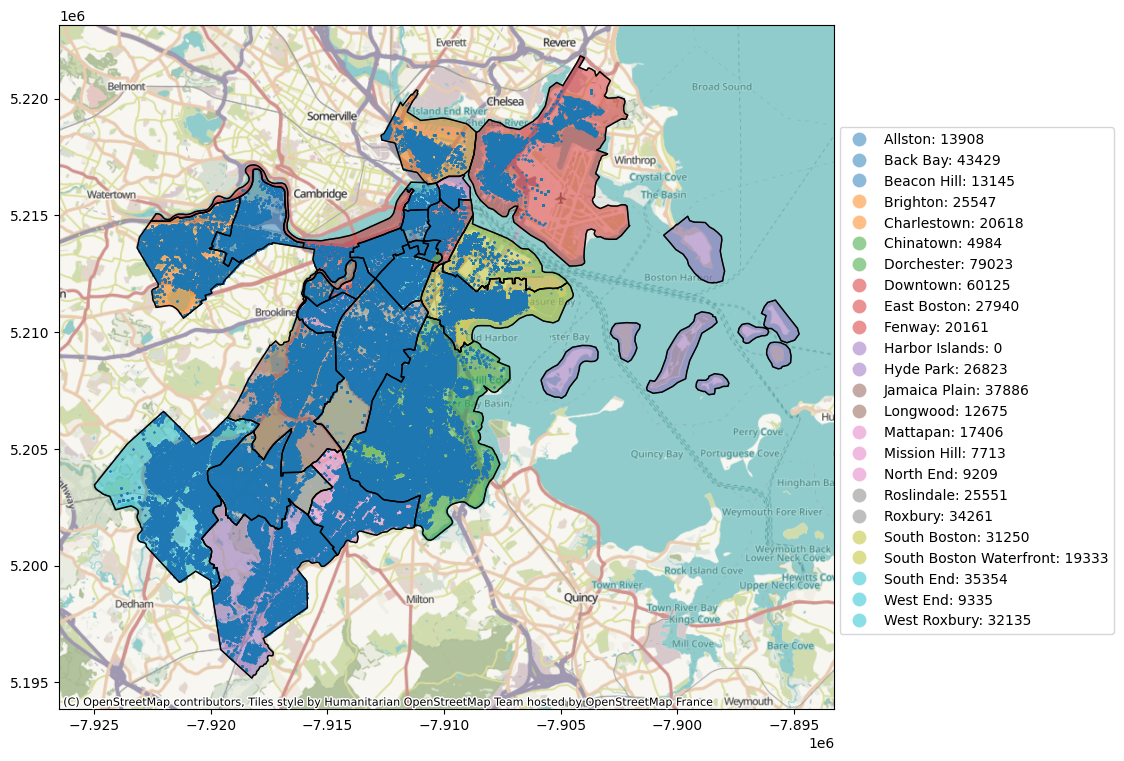

In [20]:
census["labels"] = census["BlockGr202"] + ": " + census["point counts"].apply(str)
ax = census.plot(figsize=(10, 10), alpha=0.5, edgecolor="k", column="BlockGr202",
                 legend=True, legend_kwds={"loc": "lower right", "bbox_to_anchor":(1.37, 0.1),                                    
                                           "labels": census["labels"].to_list()})
gabp.plot(ax=ax, markersize=0.1)
census.plot(ax=ax, facecolor="none", edgecolor="k")
cx.add_basemap(ax, crs=census.crs)

In [21]:
# Spacial join points to neighborhood (within relationship)
gabp["Neighborhood"] = gabp.sjoin(census, predicate="within")["BlockGr202"]

In [23]:
import distinctipy
n = census["BlockGr202"].count()
colors = distinctipy.get_colors(n, n_attempts=10)
# distinctipy.color_swatch(colors)
cmap = distinctipy.get_colormap(colors)

#### Filtered article 80

Number of points 1738


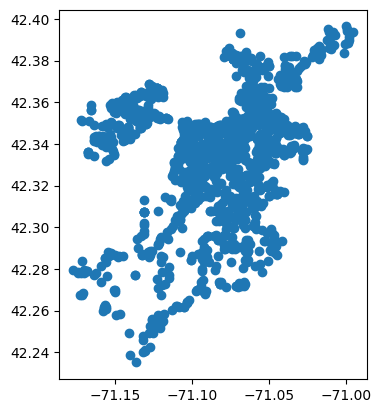

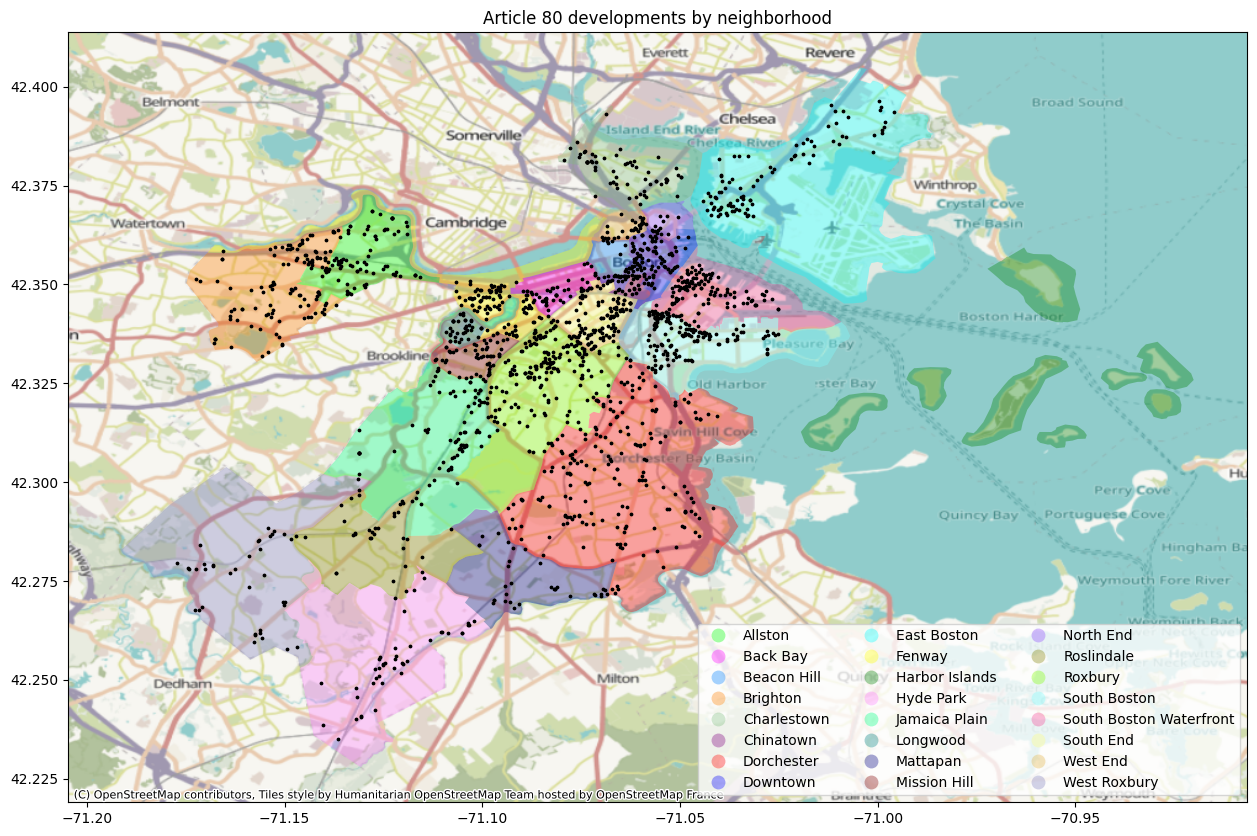

In [24]:
a80 = pd.read_csv("./proj_data/cleaned_a80.csv")
a80.dropna(subset=["lon", "lat"], inplace=True)
cen = census.copy()
census.to_crs("EPSG:4326", inplace=True)
lat_range = (42, 43)
lon_range = (-72, -70)
f_a80 = a80[(a80['lat'] >= lat_range[0]) & (a80['lat'] <= lat_range[1]) &
                   (a80['lon'] >= lon_range[0]) & (a80['lon'] <= lon_range[1])]
# plt.scatter(f_a80.lat,f_a80.lon)
# plt.show()
fa80 = gpd.GeoDataFrame(
    f_a80, geometry=gpd.points_from_xy(f_a80["lon"], f_a80["lat"], crs="EPSG:4326")
)
fa80.plot()
fa80.to_crs(census.crs, inplace=True)
print(f'Number of points {fa80["geometry"].count()}')
ax = census.plot(column="BlockGr202", alpha=0.35, categorical=True, legend=True, cmap=cmap, figsize=(20, 10),
            legend_kwds={"loc": "lower right", "ncol": 3})
fa80.plot(ax=ax, markersize=3, color="k")
cx.add_basemap(ax, crs=census.crs)
ax.set_title("Article 80 developments by neighborhood")
plt.savefig("a80", bbox_inches='tight')

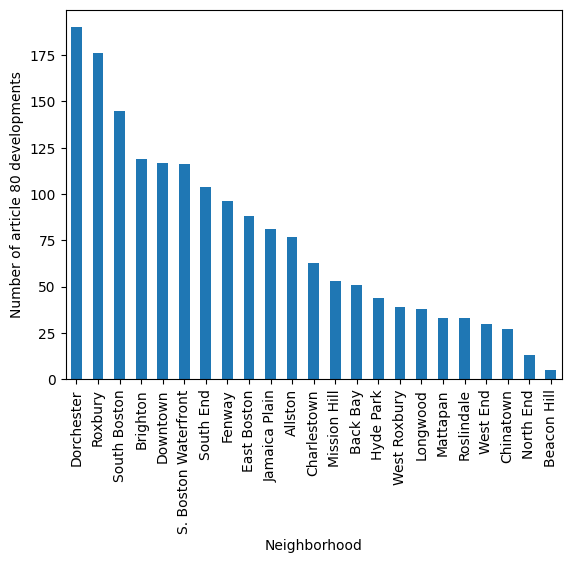

In [25]:
# Spacial join
census["BlockGr202"] = census["BlockGr202"].apply(lambda val: "S. Boston Waterfront" if val == "South Boston Waterfront" else val)
num_per_neighborhood = census.sjoin(fa80, predicate="contains").groupby("BlockGr202").size()
# num_per_neighborhood["Harbor Islands"] = 0
ax = num_per_neighborhood.sort_values(ascending=False).plot(kind="bar")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Number of article 80 developments")
plt.savefig("nums_neighborhoods", bbox_inches='tight')

In [26]:
num_per_neighborhood["Harbor Islands"] = 0

In [27]:
census = census.merge(num_per_neighborhood.rename("Development counts"), left_on="BlockGr202", right_on=num_per_neighborhood.index)

<Axes: >

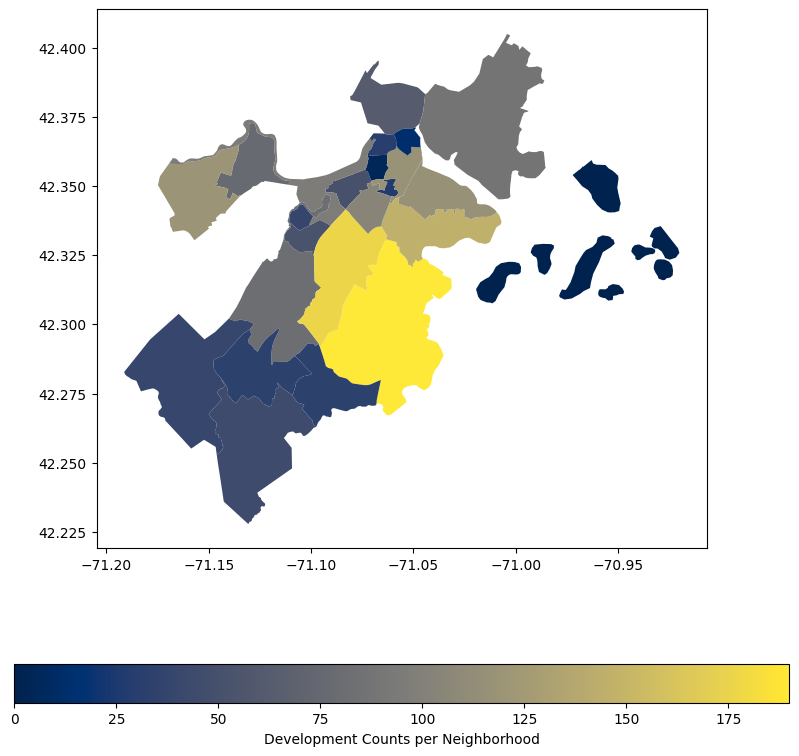

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
census.plot(column="Development counts", ax=ax, legend=True, cmap="cividis",\
                     legend_kwds={'label': "Development Counts per Neighborhood",
                         'orientation': "horizontal"})

In [29]:
census["point counts"].sum()

607811

#### Census block groups

In [30]:
census_bg = gpd.read_file('./census_block_groups/2020_Census_Block_Groups_in_Boston.shp')

In [31]:
gdata = pd.read_csv("./census-block-group-data.csv")
cols = "field concept,State/US-Abbreviation (USPS),Summary Level,Geographic Record Identifier,Geographic Code Identifier,Region,Division,State (FIPS),County (FIPS),County Subdivision (FIPS),Census Tract,Block Group,GEOID 2020 block group,Total:,White alone,Black or African American alone,Hispanic or Latino,Asian alone,American Indian and Alaska Native alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Population of two or more races:,Total:,White alone,Black or African American alone,Hispanic or Latino,Asian alone,American Indian and Alaska Native alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Population of two or more races:,Total:,Institutionalized population:,Correctional facilities for adults,Juvenile facilities,Nursing facilities/Skilled-nursing facilities,Other institutional facilities,Noninstitutionalized population:,College/University student housing,Military quarters,Other noninstitutional facilities,Total:,Occupied,Vacant"\
        .split(",")
mapper = {old: new for old, new in zip(gdata.columns, cols)}
gdata.rename(columns=mapper, inplace=True)
gdata

field concept State/US-Abbreviation (USPS)  Summary Level  \
0            PLST                           MA            150   
1            PLST                           MA            150   
2            PLST                           MA            150   
3            PLST                           MA            150   
4            PLST                           MA            150   
..            ...                          ...            ...   
576          PLST                           MA            150   
577          PLST                           MA            150   
578          PLST                           MA            150   
579          PLST                           MA            150   
580          PLST                           MA            150   

    Geographic Record Identifier  Geographic Code Identifier  Region  \
0          1500000US250250001011                2.500000e+11       1   
1          1500000US250250001012                2.500000e+11       1   
2          1500000US250250001021                2.500000e+11       1   
3          1500000US250250001022                2.500000e+11       1   
4          1500000US250250002011                2.500000e+11       1   
..                           ...                         ...     ...   
576        1500000US250259816001                2.500000e+11       1   
577        1500000US250259817001                2.500000e+11       1   
578        1500000US250259818001                2.500000e+11       1   
579        1500000US250259819001                2.500000e+11       1   
580        1500000US250259901010                2.500000e+11       1   

     Division  State (FIPS)  County (FIPS)  County Subdivision (FIPS)  ...  \
0           1            25             25                        NaN  ...   
1           1            25             25                        NaN  ...   
2           1            25             25                        NaN  ...   
3           1            25             25                        NaN  ...   
4           1            25             25                        NaN  ...   
..        ...           ...            ...                        ...  ...   
576         1            25             25                        NaN  ...   
577         1            25             25                        NaN  ...   
578         1            25             25                        NaN  ...   
579         1            25             25                        NaN  ...   
580         1            25             25                        NaN  ...   

     Juvenile facilities  Nursing facilities/Skilled-nursing facilities  \
0                      0                                              0   
1                      0                                              0   
2                      0                                              0   
3                      7                                              0   
4                      0                                              0   
..                   ...                                            ...   
576                    0                                              0   
577                    0                                              0   
578                    0                                              0   
579                    0                                              0   
580                    0                                              0   

     Other institutional facilities  Noninstitutionalized population:  \
0                                 0                                 0   
1                                 0                                10   
2                                 0                                 4   
3                                 0                                 6   
4                                 0                                 0   
..                              ...                               ...   
576      

<Axes: >

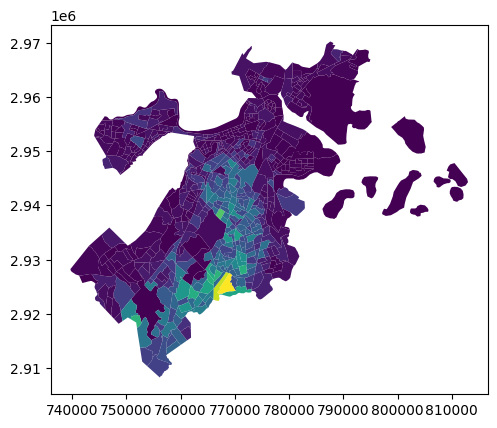

In [32]:
gdata["geoid20"] = gdata["Geographic Record Identifier"].str.split("US").apply(lambda x: x[1])
census_combined = census_bg.merge(gdata, on="geoid20")
census_combined["Black or African American alone"]
census_unique = census_combined.loc[:,~census_combined.columns.duplicated()].copy() # make new dataframe with unique columns names
census_unique.plot(column="Black or African American alone")

In [33]:
gabp.to_crs(census_unique.crs, inplace=True)
num_per_bg = census_unique.sjoin(gabp, predicate="contains").groupby("geoid20").size()

In [34]:
census_unique = census_unique.merge(num_per_bg.rename("dev counts"), how="left", left_on="geoid20", right_on=num_per_bg.index)

In [35]:
census_unique["dev counts"].fillna(0, inplace=True)
census_unique["dev counts"].isna().sum()

0

<Axes: >

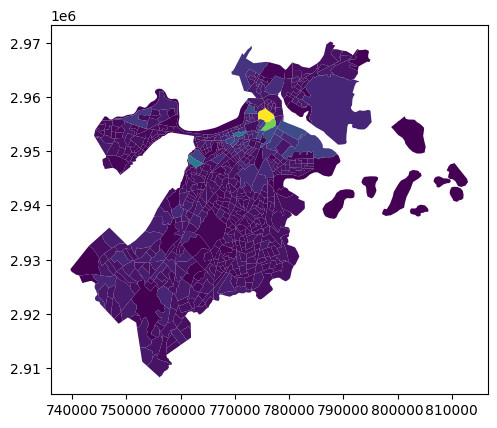

In [36]:
census_unique.plot(column="dev counts")

####  Per-demographic group Lorenz curves and Gini coefficients

In [37]:
sums = {col: census_unique[col].sum() for col in ["Total:", "dev counts"]}
sums

{'Total:': 675647, 'dev counts': 607708.0}

Total

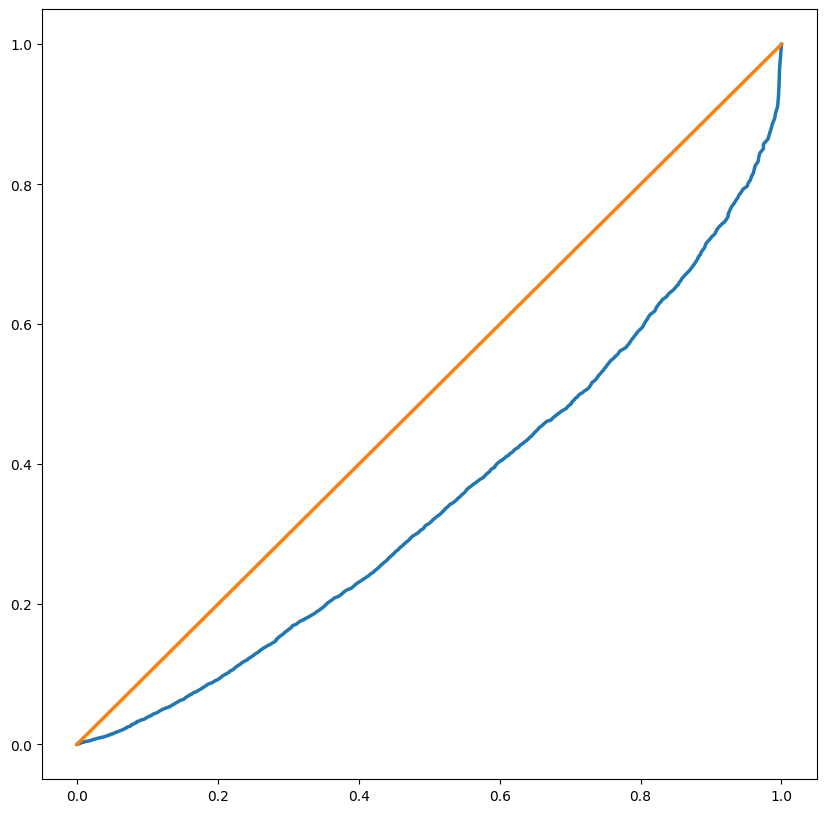

In [38]:
census_unique.sort_values(by="dev counts", ascending=True, inplace=True)
sum_pop, sum_dev = 0, 0
ratios_pop, ratios_dev = [], []
for i, row in census_unique.iterrows():
    sum_pop += row["Total:"]
    sum_dev += row["dev counts"]
    r_pop = sum_pop / sums["Total:"]
    r_dev = sum_dev / sums["dev counts"]
    ratios_pop.append(r_pop)
    ratios_dev.append(r_dev)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ratios_pop, ratios_dev, label="equal", linewidth=2.5)
# ax.scatter(ratios_pop, ratios_dev)
ax.plot(ratios_pop, ratios_pop, label="actual", linewidth=2.5)
# ax.scatter(ratios_pop, ratios_pop)

In [39]:
from sklearn.metrics import auc
lorenz = auc(ratios_pop, ratios_dev)
full = 0.5
gini = (full - lorenz) / full
gini

0.3025270833377619

Relatively equal 

In [40]:
race_cols = [ "Total:", 'White alone',
       'Black or African American alone', 'Hispanic or Latino', 'Asian alone',
       'American Indian and Alaska Native alone',
       'Native Hawaiian and Other Pacific Islander alone',
       'Some Other Race alone', 'Population of two or more races:']
sums_r = {col: census_unique[col].sum() for col in ["dev counts"] + race_cols}
sums_r

{'dev counts': 607708.0,
 'Total:': 675647,
 'White alone': 301464,
 'Black or African American alone': 129264,
 'Hispanic or Latino': 126113,
 'Asian alone': 75588,
 'American Indian and Alaska Native alone': 989,
 'Native Hawaiian and Other Pacific Islander alone': 251,
 'Some Other Race alone': 9257,
 'Population of two or more races:': 32721}

Gini coefficient for Total:: 0.3025212148015634
Gini coefficient for White alone: 0.1810622585182826
Gini coefficient for Black or African American alone: 0.44628985742231936
Gini coefficient for Hispanic or Latino: 0.40856686232980266
Gini coefficient for Asian alone: 0.334726051803394
Gini coefficient for American Indian and Alaska Native alone: 0.4094777790379249
Gini coefficient for Native Hawaiian and Other Pacific Islander alone: 0.45494671284911764
Gini coefficient for Some Other Race alone: 0.3920286868240797
Gini coefficient for Population of two or more races:: 0.3407458870511342


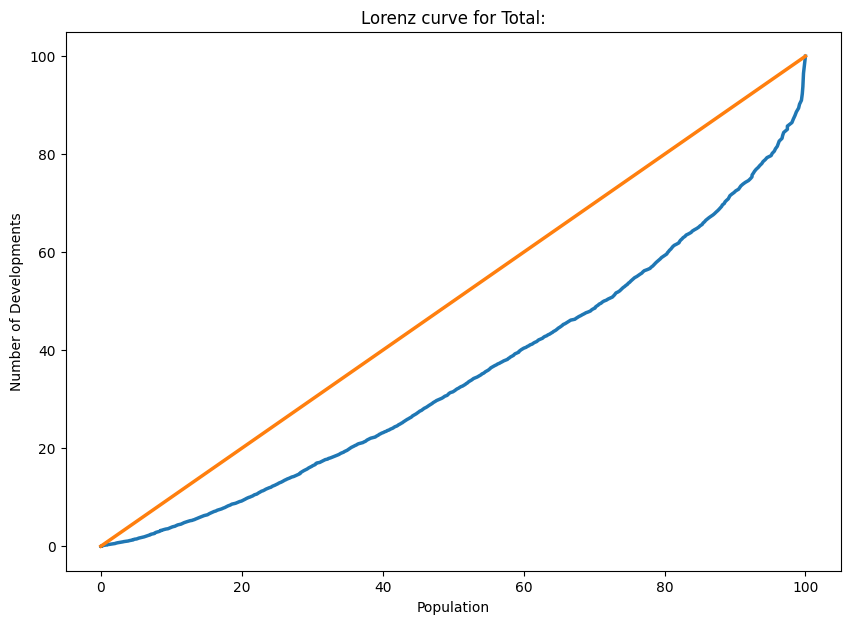

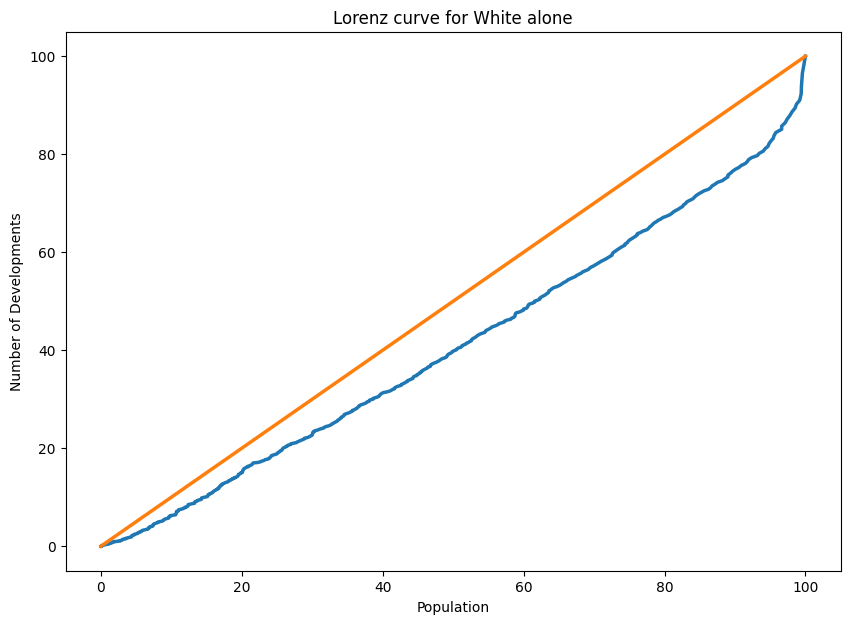

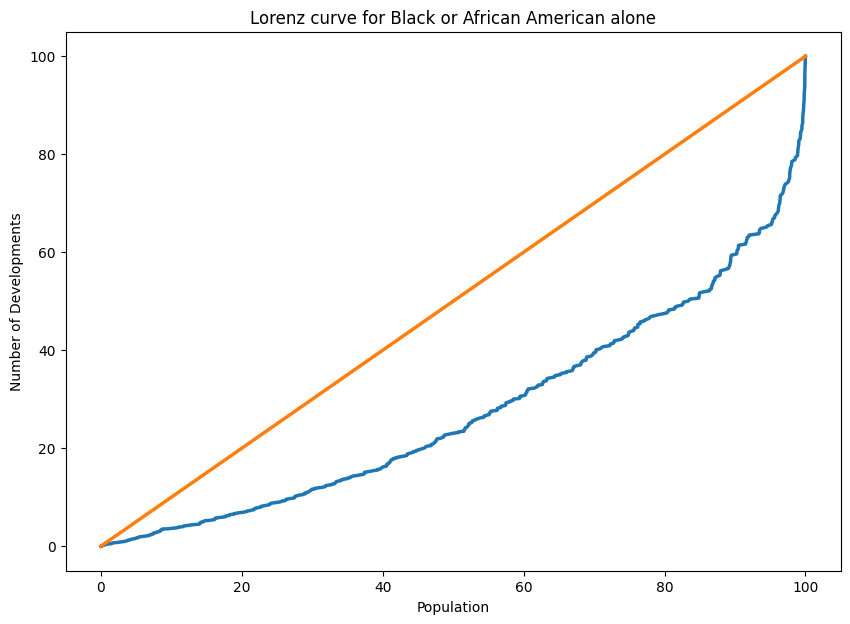

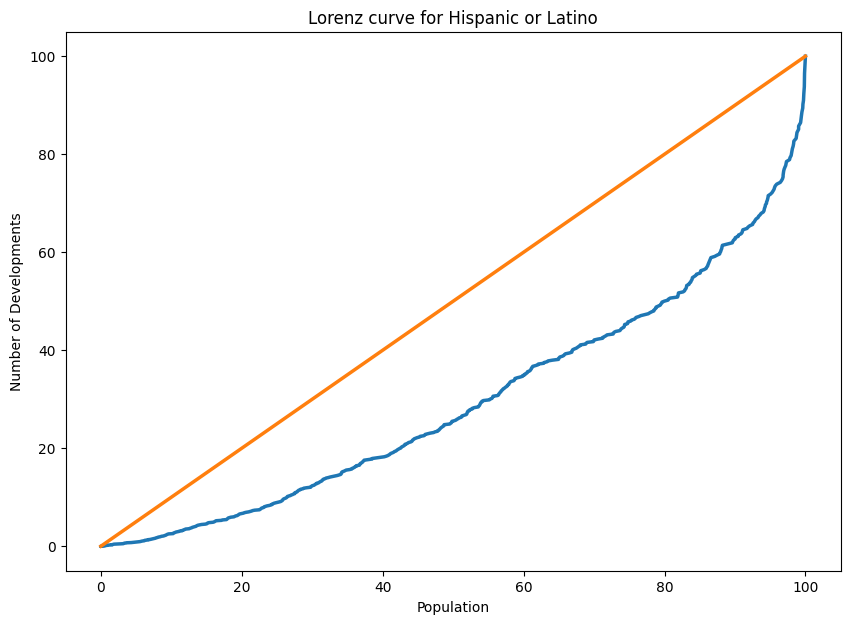

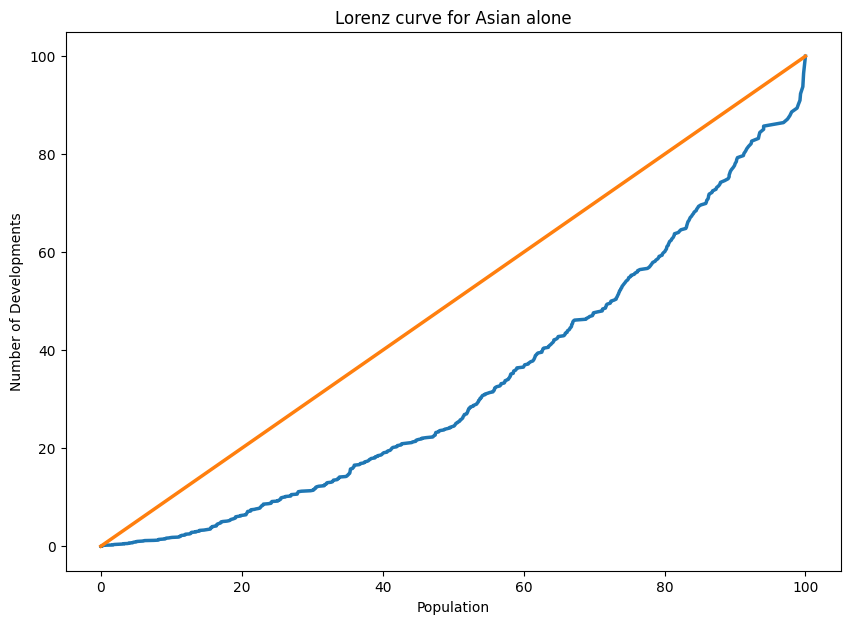

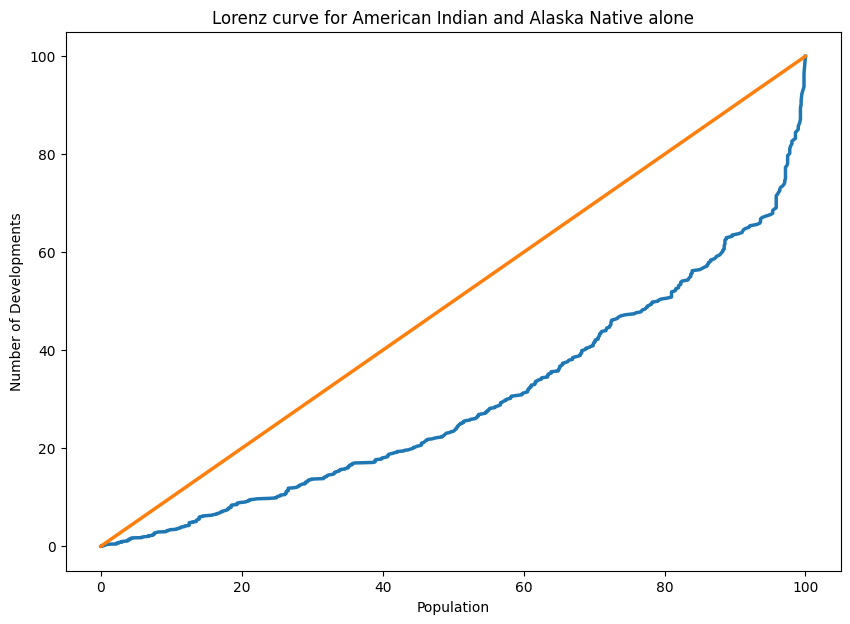

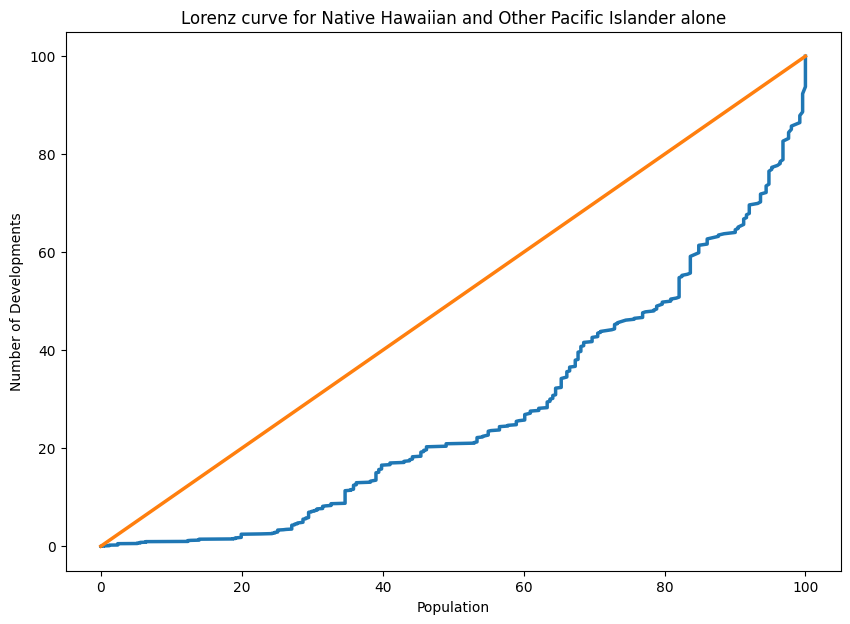

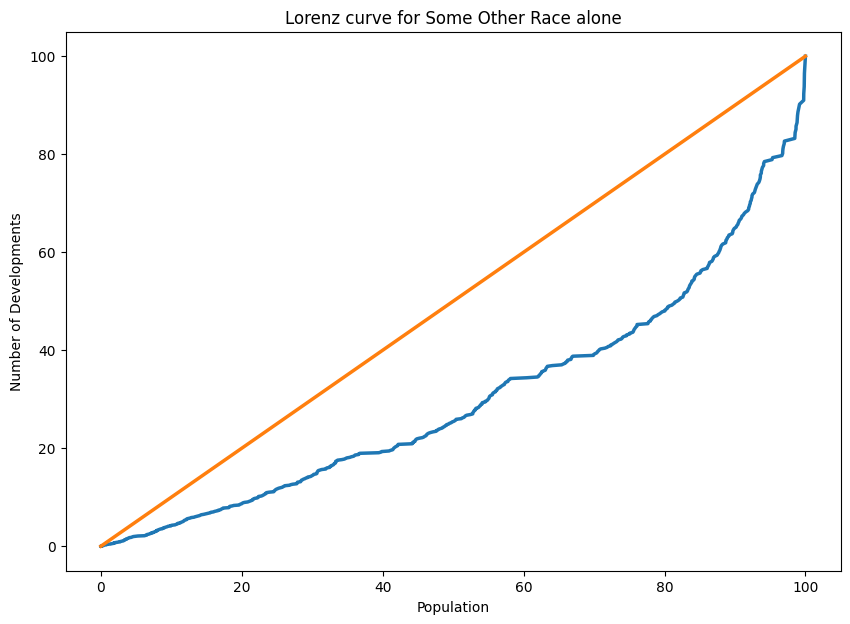

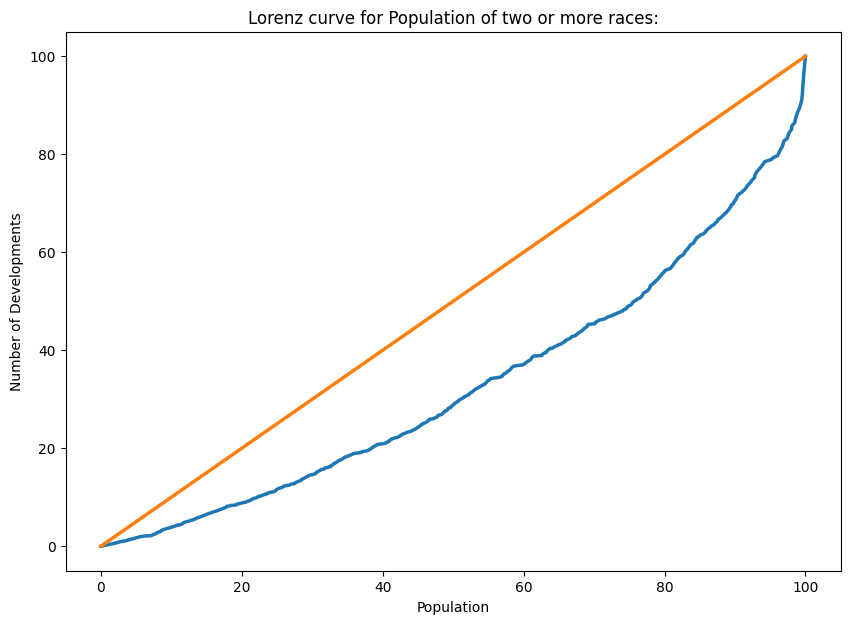

In [42]:
census_unique.sort_values(by="dev counts", ascending=True, inplace=True)
l_curves = {col: {} for col in race_cols}
for col in race_cols:
    sum_pop, sum_dev = 0, 0
    ratios_pop, ratios_dev = [], []
    for i, row in census_unique.iterrows():
        sum_pop += row[col]
        sum_dev += row["dev counts"]
        r_pop = sum_pop / sums_r[col]
        r_dev = sum_dev / sums_r["dev counts"]
        ratios_pop.append(r_pop * 100)
        ratios_dev.append(r_dev * 100)
    l_curves[col]["pop"] = ratios_pop
    l_curves[col]["dev"] = ratios_dev
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(ratios_pop, ratios_dev, label="equal", linewidth=2.5)
    ax.plot(ratios_pop, ratios_pop, label="actual", linewidth=2.5)
    ax.set_title(f"Lorenz curve for {col}")
    lorenz = auc(ratios_pop, ratios_dev)
    full = 5000
    gini = (full - lorenz) / full
    print(f"Gini coefficient for {col}: {gini}")
    l_curves[col]["gini"] = gini
    ax.set_xlabel(f"Population")
    ax.set_ylabel(f"Number of Developments")